# eda099_10
baseline再構築  

無印：フィルタなし  
仰角マスク60度
fixed

In [1]:
# import library
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_circles
import seaborn as sns
from tqdm.notebook import tqdm
import pathlib
import plotly
import plotly.express as px
import itertools
import lightgbm as lgb
from optuna.integration import lightgbm as optuna_lgb
import simdkalman
import optuna
import pyproj
from pyproj import Proj, transform
from sklearn import metrics
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix, accuracy_score
pd.set_option('display.max_rows', 100)
from math import * 
import scipy.optimize as opt
import multiprocessing
pd.set_option('display.max_columns', 50)

In [2]:
import ipynb_path

def get_nb_name():
    nb_path = ipynb_path.get()
    nb_name = nb_path.rsplit('/',1)[1].replace('.ipynb','')
    return nb_name

In [3]:
# directory setting
nb_name = get_nb_name()
INPUT = '../input/google-smartphone-decimeter-challenge'
OUTPUT = '../output/' + nb_name
os.makedirs(OUTPUT, exist_ok=True)

# utils

In [4]:
def get_train_score(df, gt):
    gt = gt.rename(columns={'latDeg':'latDeg_gt', 'lngDeg':'lngDeg_gt'})
    df = df.merge(gt, on=['collectionName', 'phoneName', 'millisSinceGpsEpoch'], how='inner')
    # calc_distance_error
    df['err'] = calc_haversine(df['latDeg_gt'], df['lngDeg_gt'], df['latDeg'], df['lngDeg'])
    # calc_evaluate_score
    df['phone'] = df['collectionName'] + '_' + df['phoneName']
    res = df.groupby('phone')['err'].agg([percentile50, percentile95])
    res['p50_p90_mean'] = (res['percentile50'] + res['percentile95']) / 2 
    score = res['p50_p90_mean'].mean()
    return score

In [5]:
def calc_haversine(lat1, lon1, lat2, lon2):
    """Calculates the great circle distance between two points
    on the earth. Inputs are array-like and specified in decimal degrees.
    """
    RADIUS = 6_367_000
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    dist = 2 * RADIUS * np.arcsin(a**0.5)
    return dist

In [6]:
def visualize_trafic(df, center, zoom=9):
    fig = px.scatter_mapbox(df,
                            
                            # Here, plotly gets, (x,y) coordinates
                            lat="latDeg",
                            lon="lngDeg",
                            
                            #Here, plotly detects color of series
                            color="phoneName",
                            labels="phoneName",
                            
                            zoom=zoom,
                            center=center,
                            height=600,
                            width=800)
    fig.update_layout(mapbox_style='stamen-terrain')
    fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
    fig.update_layout(title_text="GPS trafic")
    fig.show()
    
def visualize_collection(df, collection):
    target_df = df[df['collectionName']==collection].copy()
    lat_center = target_df['latDeg'].mean()
    lng_center = target_df['lngDeg'].mean()
    center = {"lat":lat_center, "lon":lng_center}
    
    visualize_trafic(target_df, center)

In [7]:
# ground_truth
def get_ground_truth():
    p = pathlib.Path(INPUT)
    gt_files = list(p.glob('train/*/*/ground_truth.csv'))

    gts = []
    for gt_file in gt_files:
        gts.append(pd.read_csv(gt_file))
    ground_truth = pd.concat(gts)

    return ground_truth

In [8]:
def percentile50(x):
    return np.percentile(x, 50)
def percentile95(x):
    return np.percentile(x, 95)

In [9]:
class train_result:
    def __init__(self, df):
        self.df = df
        self.gt = get_ground_truth()
        self.bl = pd.read_csv(INPUT + '/' + 'baseline_locations_train.csv')
        
        self.gt = self.gt.rename(columns={'latDeg':'latDeg_gt', 'lngDeg':'lngDeg_gt'})
        self.df = self.df.merge(self.gt, on=['collectionName', 'phoneName', 'millisSinceGpsEpoch'], how='inner')
        self.df['phone'] = self.df['collectionName'] + '_' + self.df['phoneName']
        self.df['err'] =  calc_haversine(self.df['latDeg_gt'], self.df['lngDeg_gt'], self.df['latDeg'], self.df['lngDeg'])
        
        self.phone_res = self.calc_err('phone')
        self.clc_res = self.calc_err('collectionName')
        self.phonename_res = self.calc_err('phoneName')
        
    def calc_err(self, by):
        res = self.df.groupby(by)['err'].agg([percentile50, percentile95])
        res['p50_p90_mean'] = (res['percentile50'] + res['percentile95']) / 2
        return res
    
    @property
    def score(self):
        return self.phone_res['p50_p90_mean'].mean()
    @property
    def raw_data(self):
        return self.df
    @property
    def err(self):
        return self.phone_res
    @property
    def collection_err(self):
        return self.clc_res
    @property
    def phonename_err(self):
        return self.phonename_res
    
    def viz_map(self, collection, show_gt=True, show_bl=True):
        tmp = self.df[self.df['collectionName']==collection][['collectionName', 'phoneName', 'latDeg', 'lngDeg']]
        tmp2 = self.df[self.df['collectionName']==collection][['collectionName', 'phoneName', 'latDeg_gt', 'lngDeg_gt']]
        tmp2 = tmp2.rename(columns={'latDeg_gt':'latDeg', 'lngDeg_gt':'lngDeg'})
        tmp2['phoneName'] = tmp2['phoneName'] + '_GT'
        tmp3 = self.bl[self.bl['collectionName']==collection][['collectionName', 'phoneName', 'latDeg', 'lngDeg']]
        tmp3['phoneName'] = tmp3['phoneName'] + '_BL'
        
        if show_gt:
            tmp = tmp.append(tmp2)
        if show_bl:
            tmp = tmp.append(tmp3)
        visualize_collection(tmp, collection)

In [10]:
def get_data():
    base_train = pd.read_csv(INPUT + '/' + 'baseline_locations_train.csv')
    base_test = pd.read_csv(INPUT + '/' + 'baseline_locations_test.csv')
    sample_sub = pd.read_csv(INPUT + '/' + 'sample_submission.csv')
    ground_truth = pd.read_csv(INPUT + '/prep/ground_truth_train.csv')
    return base_train, base_test, sample_sub, ground_truth

In [11]:
def ecef2lla(x, y, z):
    # x, y and z are scalars or vectors in meters
    x = np.array([x]).reshape(np.array([x]).shape[-1], 1)
    y = np.array([y]).reshape(np.array([y]).shape[-1], 1)
    z = np.array([z]).reshape(np.array([z]).shape[-1], 1)

    a=6378137
    a_sq=a**2
    e = 8.181919084261345e-2
    e_sq = 6.69437999014e-3

    f = 1/298.257223563
    b = a*(1-f)

    # calculations:
    r = np.sqrt(x**2 + y**2)
    ep_sq  = (a**2-b**2)/b**2
    ee = (a**2-b**2)
    f = (54*b**2)*(z**2)
    g = r**2 + (1 - e_sq)*(z**2) - e_sq*ee*2
    c = (e_sq**2)*f*r**2/(g**3)
    s = (1 + c + np.sqrt(c**2 + 2*c))**(1/3.)
    p = f/(3.*(g**2)*(s + (1./s) + 1)**2)
    q = np.sqrt(1 + 2*p*e_sq**2)
    r_0 = -(p*e_sq*r)/(1+q) + np.sqrt(0.5*(a**2)*(1+(1./q)) - p*(z**2)*(1-e_sq)/(q*(1+q)) - 0.5*p*(r**2))
    u = np.sqrt((r - e_sq*r_0)**2 + z**2)
    v = np.sqrt((r - e_sq*r_0)**2 + (1 - e_sq)*z**2)
    z_0 = (b**2)*z/(a*v)
    h = u*(1 - b**2/(a*v))
    phi = np.arctan((z + ep_sq*z_0)/r)
    lambd = np.arctan2(y, x)

    return phi*180/np.pi, lambd*180/np.pi, h

# baselineの再作成

In [12]:
def prepare_calc_baseline(df):
    light_speed = 299_792_458
    omega_e = 7.2921151467e-5
    
    # Corrected pseudorange according to data instructions
    df['correctedPrM'] = df['rawPrM'] + \
                         df['satClkBiasM'] - \
                         df['isrbM'] - \
                         df['ionoDelayM'] - \
                         df['tropoDelayM']
    
    # Time it took for signal to travel
    df['transmissionTimeSeconds'] = df['correctedPrM'] / light_speed
    
    # Compute true sat positions at arrival time
    df['xSatPosMRotated'] = \
        np.cos(omega_e * df['transmissionTimeSeconds']) * df['xSatPosM'] \
        + np.sin(omega_e * df['transmissionTimeSeconds']) * df['ySatPosM']

    df['ySatPosMRotated'] = \
        - np.sin(omega_e * df['transmissionTimeSeconds']) * df['xSatPosM'] \
        + np.cos(omega_e * df['transmissionTimeSeconds']) * df['ySatPosM']

    df['zSatPosMRotated'] = df['zSatPosM']
    
    # Uncertainty weight for the WLS method
    df['uncertaintyWeight'] = 1 / df['rawPrUncM']
    
    return df

In [13]:
def calc_baseline_point(df):

    def distance(sat_pos, x):
        sat_pos_diff = sat_pos.copy(deep=True)

        sat_pos_diff['xSatPosMRotated'] = sat_pos_diff['xSatPosMRotated'] - x[0]
        sat_pos_diff['ySatPosMRotated'] = sat_pos_diff['ySatPosMRotated'] - x[1]
        sat_pos_diff['zSatPosMRotated'] = sat_pos_diff['zSatPosMRotated'] - x[2]

        sat_pos_diff['d'] = sat_pos_diff['uncertaintyWeight'] * \
                            (np.sqrt((sat_pos_diff['xSatPosMRotated']**2 + sat_pos_diff['ySatPosMRotated']**2 + sat_pos_diff['zSatPosMRotated']**2)) + \
                             x[3] - sat_pos_diff['correctedPrM'])

        return sat_pos_diff['d']

    def distance_fixed_satpos(x):
        return distance(df[['xSatPosMRotated', 'ySatPosMRotated', 'zSatPosMRotated', 'correctedPrM', 'uncertaintyWeight']], x)
    
    x0 = [0,0,0,0]
    opt_res = opt.least_squares(distance_fixed_satpos, x0)
    # Optimiser yields a position in the ECEF coordinates
    opt_res_pos = opt_res.x
    
    # ECEF position to lat/long
    wls_estimated_pos = ecef2lla(*opt_res_pos[:3])
    wls_estimated_pos = np.squeeze(wls_estimated_pos)
    
    return wls_estimated_pos[0], wls_estimated_pos[1]

In [14]:
def get_derived_data(train_test, collection, phonename):
    derived = pd.read_csv(INPUT + f'/{train_test}/{collection}/{phonename}/{phonename}_derived.csv')
    raw = pd.read_csv(INPUT + f'/prep/gnss/{train_test}/{collection}/{phonename}/Raw.csv')
    status = pd.read_csv(INPUT + f'/prep/gnss/{train_test}/{collection}/{phonename}/Status.csv')
    
    delta_millis = derived['millisSinceGpsEpoch'] - derived['receivedSvTimeInGpsNanos'] / 1e6
    remove_signals = (delta_millis > 0) & (delta_millis < 300)
    derived = derived[~remove_signals].copy()
    
    # Assume we've loaded a dataframe from _GnssLog.txt for only lines beginning with "Raw", we denote this df_raw. Next, assume we've loaded a dataframe from _derived.csv. We denote this df_derived.

    # Create a new column in df_raw that corresponds to df_derived['MillisSinceGpsEpoch']
    raw['millisSinceGpsEpoch'] = np.floor( (raw['TimeNanos'] - raw['FullBiasNanos']) / 1000000.0).astype(int)
    
    # Change each value in df_derived['MillisSinceGpsEpoch'] to be the prior epoch.
    raw_timestamps = raw['millisSinceGpsEpoch'].unique()
    derived_timestamps = derived['millisSinceGpsEpoch'].unique()

    # The timestamps in derived are one epoch ahead. We need to map each epoch
    # in derived to the prior one (in Raw).
    indexes = np.searchsorted(raw_timestamps, derived_timestamps)
    from_t_to_fix_derived = dict(zip(derived_timestamps, raw_timestamps[indexes-1]))
    derived['millisSinceGpsEpoch'] = np.array(list(map(lambda v: from_t_to_fix_derived[v], derived['millisSinceGpsEpoch'])))

    # Compute signal_type in df_raw.
    # Map from constellation id to frequencies and signals.
    CONSTEL_FREQ_TABLE = {
        0: {'UNKNOWN': (0, 999999999999)},
        1: {
            'GPS_L1': (1563000000, 1587000000),
            'GPS_L2': (1215000000, 1240000000),
            'GPS_L5': (1164000000, 1189000000)
        },
        3: {
            'GLO_G1': (1593000000, 1610000000),
            'GLO_G2': (1237000000, 1254000000)
        },
        4: {
            'QZS_J1': (1563000000, 1587000000),
            'QZS_J2': (1215000000, 1240000000),
            'QZS_J5': (1164000000, 1189000000)
        },
        5: {
            'BDS_B1C': (1569000000, 1583000000),
            'BDS_B1I': (1553000000, 1568990000),
            'BDS_B2A': (1164000000, 1189000000),
            'BDS_B2B': (1189000000, 1225000000)
        },
        6: {
            'GAL_E1': (1559000000, 1591000000),
            'GAL_E5A': (1164000000, 1189000000),
            'GAL_E5B': (1189000000, 1218000000),
            'GAL_E6': (1258000000, 1300000000)
        },
        7: {
            'IRN_S': (2472000000, 2512000000),
            'IRN_L5': (1164000000, 1189000000)
        },
    }

    def SignalTypeFromConstellationAndFequency(constel, freq_hz):
        'Returns the signal type as a string for the given constellation and frequency.'
        freqs = CONSTEL_FREQ_TABLE.get(constel, {})
        for id_freq_range in freqs.items():
            rng = id_freq_range[1]
            if rng[0] <= freq_hz <= rng[1]:
                return id_freq_range[0]
        return 'UNKNOWN'

    signal_types = itertools.chain(*[c.keys() for c in CONSTEL_FREQ_TABLE.values()])
    sig_type_cat = pd.api.types.CategoricalDtype(categories=signal_types)
    raw['signalType'] = raw.apply(lambda r: SignalTypeFromConstellationAndFequency(r.ConstellationType, r.CarrierFrequencyHz), axis=1).astype(sig_type_cat)

    # Fix QZS Svids issue. 

    # The SVID of any QZS sat in derived may be changed. Since it may be a many to one relationship, we'll need to adjust the values in Raw.
    new_to_old = {1:(183, 193), 2:(184, 194, 196), 3:(187, 189, 197, 199), 4:(185, 195, 200)}
    # Maps original svid to new svid for only ConstellationType=4.
    old_to_new={}
    for new_svid, old_svids in new_to_old.items():
        for s in old_svids:
            old_to_new[s] = new_svid
    raw['svid'] = raw.apply(lambda r: old_to_new.get(r.Svid, r.Svid) if r.ConstellationType == 4 else r.Svid, axis=1)
    del raw['collectionName']
    del raw['phoneName']
    
    derived = derived.merge(raw, on=['millisSinceGpsEpoch', 'svid', 'signalType'], how='left')
    
    # status
    status['millisSinceGpsEpoch'] = status['UnixTimeMillis'] - 315964800000 + 18000
    status['svid'] = status.apply(lambda r: old_to_new.get(r.Svid, r.Svid) if r.ConstellationType == 4 else r.Svid, axis=1)
    status['signalType'] = status.apply(lambda r: SignalTypeFromConstellationAndFequency(r.ConstellationType, r.CarrierFrequencyHz), axis=1).astype(sig_type_cat)
    del status['collectionName']
    del status['phoneName']
    status = status.drop_duplicates(subset=['svid', 'signalType', 'millisSinceGpsEpoch'])
    
    sv_sig = derived[['svid', 'signalType']].drop_duplicates()
    output_df = pd.DataFrame()
    for svid, signal in zip(sv_sig['svid'], sv_sig['signalType']):
        derived_tmp = derived[(derived['svid']==svid)&(derived['signalType']==signal)].copy()
        status_tmp = status[(status['svid']==svid)&(status['signalType']==signal)].copy()
        del status_tmp['svid']
        del status_tmp['signalType']
        output_tmp = pd.merge_asof(derived_tmp, status_tmp, on='millisSinceGpsEpoch', direction='nearest')
        output_df = output_df.append(output_tmp)
    
    return output_df

In [15]:
def calc_baseline(args):
    s_th = 10
    
    phone, df = args
    collection = phone.split('_')[0]
    phonename = phone.split('_')[1]
    derived = get_derived_data('train', collection, phonename)
    derived = prepare_calc_baseline(derived)
    
    #derived = derived[~(derived['MultipathIndicator']==1)].copy()
    derived = derived[derived['ElevationDegrees']>60].copy()
    derived = derived[derived['UsedInFix']==1].copy()
    
    idx = list(df.index)
    s_list = []
    n_list = []
    lat_list = []
    lng_list = []
    unc_mean_list = []
    unc_max_list = []
    
    for j,i in enumerate(idx):
        s = df.at[i, 'millisSinceGpsEpoch']
        tmp = derived[(derived['millisSinceGpsEpoch']>=s-s_th)&(derived['millisSinceGpsEpoch']<=s+s_th)].copy()
        n = tmp['svid'].nunique()
        s_list.append(s)
        n_list.append(n)
        
        if n < 4:    
            lat_list.append(np.nan)
            lng_list.append(np.nan)
            unc_mean_list.append(np.nan)
            unc_max_list.append(np.nan)        
        
        else:
            res = calc_baseline_point(tmp)
            lat_list.append(res[0])
            lng_list.append(res[1])
            unc_mean_list.append(tmp['uncertaintyWeight'].mean())
            unc_max_list.append(tmp['uncertaintyWeight'].max())
    
    output_df = pd.DataFrame()
    output_df['millisSinceGpsEpoch'] = s_list
    output_df['latDeg'] = lat_list
    output_df['lngDeg'] = lng_list
    output_df['n'] = n_list
    output_df['unc_mean'] = unc_mean_list
    output_df['unc_max'] = unc_max_list
    output_df['collectionName'] = collection
    output_df['phoneName'] = phonename
    output_df['phone'] = phone
    
    return output_df

In [16]:
def calc_baseline_test(args):
    s_th = 10
    
    phone, df = args
    collection = phone.split('_')[0]
    phonename = phone.split('_')[1]
    derived = get_derived_data('test', collection, phonename)
    derived = prepare_calc_baseline(derived)
    
    #derived = derived[~(derived['MultipathIndicator']==1)].copy()
    derived = derived[derived['ElevationDegrees']>60].copy()
    derived = derived[derived['UsedInFix']==1].copy()
    
    idx = list(df.index)
    s_list = []
    n_list = []
    lat_list = []
    lng_list = []
    unc_mean_list = []
    unc_max_list = []
    
    for j,i in enumerate(idx):
        s = df.at[i, 'millisSinceGpsEpoch']
        tmp = derived[(derived['millisSinceGpsEpoch']>=s-s_th)&(derived['millisSinceGpsEpoch']<=s+s_th)].copy()
        n = tmp['svid'].nunique()
        s_list.append(s)
        n_list.append(n)
        
        if n < 4:    
            lat_list.append(np.nan)
            lng_list.append(np.nan)
            unc_mean_list.append(np.nan)
            unc_max_list.append(np.nan)        
        
        else:
            res = calc_baseline_point(tmp)
            lat_list.append(res[0])
            lng_list.append(res[1])
            unc_mean_list.append(tmp['uncertaintyWeight'].mean())
            unc_max_list.append(tmp['uncertaintyWeight'].max())
    
    output_df = pd.DataFrame()
    output_df['millisSinceGpsEpoch'] = s_list
    output_df['latDeg'] = lat_list
    output_df['lngDeg'] = lng_list
    output_df['n'] = n_list
    output_df['unc_mean'] = unc_mean_list
    output_df['unc_max'] = unc_max_list
    output_df['collectionName'] = collection
    output_df['phoneName'] = phonename
    output_df['phone'] = phone
    
    return output_df

In [17]:
df = get_derived_data('train', '2021-04-22-US-SJC-1', 'Pixel4')

<AxesSubplot:>

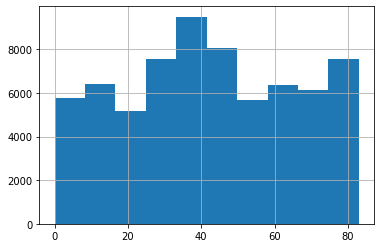

In [18]:
df['ElevationDegrees'].hist()

In [19]:
train, test, sub, gt = get_data()

In [20]:
target = ['2021-04-22-US-SJC-1_Pixel4', '2021-04-22-US-SJC-1_SamsungS20Ultra',
          '2021-04-28-US-SJC-1_Pixel4', '2021-04-28-US-SJC-1_SamsungS20Ultra',
          '2021-04-29-US-SJC-2_Pixel4', '2021-04-29-US-SJC-2_SamsungS20Ultra',
          '2021-04-28-US-MTV-1_Pixel4', '2021-04-28-US-MTV-1_Pixel5', '2021-04-28-US-MTV-1_SamsungS20Ultra',
          '2021-04-29-US-MTV-1_Pixel4', '2021-04-29-US-MTV-1_Pixel5', '2021-04-29-US-MTV-1_SamsungS20Ultra']
train = train[train['phone'].isin(target)].copy()

In [21]:
processes = multiprocessing.cpu_count()
with multiprocessing.Pool(processes=processes) as pool:
    dfs = pool.imap_unordered(calc_baseline, train.groupby('phone'))
    dfs = tqdm(dfs)
    dfs = list(dfs)
result = pd.concat(dfs)

0it [00:00, ?it/s]

In [22]:
train_tmp = train[['phone', 'millisSinceGpsEpoch', 'latDeg', 'lngDeg']].copy()
train_tmp.columns = ['phone', 'millisSinceGpsEpoch', 'latDeg_bl', 'lngDeg_bl']
result = result.merge(train_tmp, on=['phone', 'millisSinceGpsEpoch'], how='left')

In [23]:
gt['phone'] = gt['collectionName'] + '_' + gt['phoneName']
gt_tmp = gt[['phone', 'millisSinceGpsEpoch', 'latDeg', 'lngDeg']].copy()
gt_tmp.columns = ['phone', 'millisSinceGpsEpoch', 'latDeg_gt', 'lngDeg_gt']
result = result.merge(gt_tmp, on=['phone', 'millisSinceGpsEpoch'], how='left')

In [24]:
result['rb_bl_err'] = calc_haversine(result['latDeg_bl'], result['lngDeg_bl'], result['latDeg'], result['lngDeg'])
result['rb_gt_err'] = calc_haversine(result['latDeg_gt'], result['lngDeg_gt'], result['latDeg'], result['lngDeg'])
result['bl_gt_err'] = calc_haversine(result['latDeg_gt'], result['lngDeg_gt'], result['latDeg_bl'], result['lngDeg_bl'])

In [25]:
for phone in result['phone'].unique():
    tmp = result[result['phone']==phone].copy()
    null_rate = tmp['latDeg'].isnull().sum() / len(tmp)
    print(phone, null_rate)

2021-04-28-US-SJC-1_SamsungS20Ultra 1.0
2021-04-29-US-SJC-2_SamsungS20Ultra 1.0
2021-04-29-US-MTV-1_Pixel5 0.9899749373433584
2021-04-29-US-MTV-1_Pixel4 0.9232209737827716
2021-04-29-US-MTV-1_SamsungS20Ultra 0.9180229053646776
2021-04-28-US-SJC-1_Pixel4 0.8545183714001986
2021-04-29-US-SJC-2_Pixel4 0.7811158798283262
2021-04-28-US-MTV-1_Pixel5 0.345088161209068
2021-04-22-US-SJC-1_SamsungS20Ultra 0.4140127388535032
2021-04-28-US-MTV-1_SamsungS20Ultra 0.01463907117617365
2021-04-28-US-MTV-1_Pixel4 0.06853426713356678
2021-04-22-US-SJC-1_Pixel4 0.05224913494809689


In [26]:
result_grouped = result.dropna().groupby('phone')[['rb_bl_err', 'rb_gt_err', 'bl_gt_err']].agg([percentile50, percentile95]).reset_index()
result_grouped.columns = ['phone', 'rb_bl_err_p50', 'rb_bl_err_p95', 'rb_gt_err_p50', 'rb_gt_err_p95', 'bl_gt_err_p50', 'bl_gt_err_p95']
result_grouped['rb_score'] = (result_grouped['rb_gt_err_p95'] + result_grouped['rb_gt_err_p50']) / 2
result_grouped['bl_score'] = (result_grouped['bl_gt_err_p95'] + result_grouped['bl_gt_err_p50']) / 2
result_grouped

,phone,rb_bl_err_p50,rb_bl_err_p95,rb_gt_err_p50,rb_gt_err_p95,bl_gt_err_p50,bl_gt_err_p95,rb_score,bl_score
0,2021-04-22-US-SJC-1_Pixel4,21.615395,132.855514,22.513627,129.905618,7.088098,40.725059,76.209622,23.906578
1,2021-04-22-US-SJC-1_SamsungS20Ultra,28.053295,100.330345,27.706537,99.269978,8.260987,23.450183,63.488257,15.855585
2,2021-04-28-US-MTV-1_Pixel4,16.054294,73.513102,16.080769,72.881592,2.157180,7.357395,44.481181,4.757287
3,2021-04-28-US-MTV-1_Pixel5,29.335080,121.014303,29.363308,121.006186,1.707572,3.752403,75.184747,2.729988
4,2021-04-28-US-MTV-1_SamsungS20Ultra,20.775821,75.889535,20.034633,75.344921,3.401591,11.129536,47.689777,7.265563
5,2021-04-28-US-SJC-1_Pixel4,75.765534,868.992692,69.274736,865.397535,6.859778,25.555673,467.336136,16.207725
6,2021-04-29-US-MTV-1_Pixel4,47.423059,154.089111,48.830375,152.471370,3.050078,5.913644,100.650873,4.481861
7,2021-04-29-US-MTV-1_Pixel5,64.292171,201.034993,63.848499,202.857764,7.440864,12.717961,133.353132,10.079412
8,2021-04-29-US-MTV-1_SamsungS20Ultra,29.164751,109.034582,32.320471,110.071861,6.513831,9.761692,71.196166,8.137761
9,2021-04-29-US-SJC-2_Pixel4,242.908577,2275.243480,243.503800,2282.086159,5.133801,42.960063,1262.794979,24.046932


In [27]:
result.to_csv(OUTPUT + '/result.csv', index=False)
result_grouped.to_csv(OUTPUT + '/result_grouped.csv', index=False)

In [28]:
result_grouped[['rb_score', 'bl_score']].mean()

rb_score    234.238487
bl_score     11.746869
dtype: float64

In [29]:
target = ['2021-04-22-US-SJC-1_Pixel4', '2021-04-22-US-SJC-1_SamsungS20Ultra',
          '2021-04-28-US-SJC-1_Pixel4', '2021-04-28-US-SJC-1_SamsungS20Ultra',
          '2021-04-29-US-SJC-2_Pixel4', '2021-04-29-US-SJC-2_SamsungS20Ultra']
result_grouped[result_grouped['phone'].isin(target)][['rb_score', 'bl_score']].mean()

rb_score    467.457249
bl_score     20.004205
dtype: float64

In [30]:
target = ['2021-04-28-US-MTV-1_Pixel4', '2021-04-28-US-MTV-1_Pixel5', '2021-04-28-US-MTV-1_SamsungS20Ultra',
          '2021-04-29-US-MTV-1_Pixel4', '2021-04-29-US-MTV-1_Pixel5', '2021-04-29-US-MTV-1_SamsungS20Ultra']
result_grouped[result_grouped['phone'].isin(target)][['rb_score', 'bl_score']].mean()

rb_score    78.759312
bl_score     6.241979
dtype: float64

In [31]:
result

,millisSinceGpsEpoch,latDeg,lngDeg,n,unc_mean,unc_max,collectionName,phoneName,phone,latDeg_bl,lngDeg_bl,latDeg_gt,lngDeg_gt,rb_bl_err,rb_gt_err,bl_gt_err
0,1303675174000,NaN,NaN,3,NaN,NaN,2021-04-28-US-SJC-1,SamsungS20Ultra,2021-04-28-US-SJC-1_SamsungS20Ultra,37.334131,-121.900276,37.334152,-121.900258,NaN,NaN,2.816915
1,1303675175000,NaN,NaN,3,NaN,NaN,2021-04-28-US-SJC-1,SamsungS20Ultra,2021-04-28-US-SJC-1_SamsungS20Ultra,37.334096,-121.900277,37.334152,-121.900258,NaN,NaN,6.427852
2,1303675176000,NaN,NaN,3,NaN,NaN,2021-04-28-US-SJC-1,SamsungS20Ultra,2021-04-28-US-SJC-1_SamsungS20Ultra,37.334104,-121.900261,37.334152,-121.900258,NaN,NaN,5.344172
3,1303675177000,NaN,NaN,3,NaN,NaN,2021-04-28-US-SJC-1,SamsungS20Ultra,2021-04-28-US-SJC-1_SamsungS20Ultra,37.334093,-121.900247,37.334152,-121.900258,NaN,NaN,6.577915
4,1303675178000,NaN,NaN,3,NaN,NaN,2021-04-28-US-SJC-1,SamsungS20Ultra,2021-04-28-US-SJC-1_SamsungS20Ultra,37.334108,-121.900216,37.334152,-121.900258,NaN,NaN,6.081067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25330,1303163462446,37.334695,-121.899404,4,0.379168,0.555864,2021-04-22-US-SJC-1,Pixel4,2021-04-22-US-SJC-1_Pixel4,37.334590,-121.899411,37.334599,-121.899427,11.654138,10.873989,1.747994
25331,1303163463446,37.334475,-121.899174,4,0.395447,0.555864,2021-04-22-US-SJC-1,Pixel4,2021-04-22-US-SJC-1_Pixel4,37.334579,-121.899403,37.334599,-121.899427,23.316549,26.261417,3.040781
25332,1303163464446,37.334460,-121.899135,5,0.324936,0.476417,2021-04-22-US-SJC-1,Pixel4,2021-04-22-US-SJC-1_Pixel4,37.334589,-121.899423,37.334599,-121.899427,29.162102,30.063186,1.168164
25333,1303163465446,37.334514,-121.898975,5,0.362222,0.555864,2021-04-22-US-SJC-1,Pixel4,2021-04-22-US-SJC-1_Pixel4,37.334621,-121.899401,37.334599,-121.899427,39.529515,41.090114,3.407626


# test

In [32]:
target = ['2021-04-22-US-SJC-2_SamsungS20Ultra', '2021-04-29-US-SJC-3_Pixel4', '2021-04-29-US-SJC-3_SamsungS20Ultra']
test = test[test['phone'].isin(target)].copy()

In [33]:
processes = multiprocessing.cpu_count()
with multiprocessing.Pool(processes=processes) as pool:
    dfs = pool.imap_unordered(calc_baseline_test, test.groupby('phone'))
    dfs = tqdm(dfs)
    dfs = list(dfs)
result = pd.concat(dfs)

0it [00:00, ?it/s]

In [34]:
result.to_csv(OUTPUT + '/result_test.csv', index=False)

In [35]:
for phone in result['phone'].unique():
    tmp = result[result['phone']==phone].copy()
    null_rate = tmp['latDeg'].isnull().sum() / len(tmp)
    print(phone, null_rate)

2021-04-29-US-SJC-3_SamsungS20Ultra 0.7438136826783115
2021-04-29-US-SJC-3_Pixel4 0.10106114199090449
2021-04-22-US-SJC-2_SamsungS20Ultra 0.07530120481927711
